# 僅差

In [1]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from scipy import stats
import statsmodels.api as sm

%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn-pastel')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tq

import matplotlib as mpl
font = {"family":"osaka"}
mpl.rc('font', **font)

sys.path.append("..")
from utils.util_functions import *

pd.set_option('display.max_rows', 500)

In [2]:
#event_df = make_df(data_dir=DETAIL_DATA_DIR_MLB)
#event_df = pd.read_csv(os.path.join(ROOT_DIR, "event_df.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2017 = make_df(end=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2017 = pd.read_csv(os.path.join(ROOT_DIR, "df_2017.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2018 = make_df(start=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2018 = pd.read_csv(os.path.join(ROOT_DIR, "df_2018.csv"), index_col=0, encoding="cp932", dtype=object)
files = os.listdir(DETAIL_DATA_DIR_MLB)[1:]
names = pd.Series(files).apply(lambda x: int(x.split(".")[0]))
files_2017 = names[names<=1944417].apply(lambda x: str(x)+".csv")
files_2018 = names[names>1944417].apply(lambda x: str(x)+".csv")
column = "得点"
teams_mlb = list(set(pd.read_csv(os.path.join(SCORE_DATA_DIR_MLB, "score_mlb.csv"), encoding="cp932", index_col=0).表チーム))
teams_mlb.remove("ア・リーグ")
first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']

In [53]:
def pos_neg(team, nlead=5, nbehind=4, year="both"):
    if year == "both":
        df = event_df[event_df.攻撃チーム==team]
    elif year == 2018:
        df = df_2018[df_2018.攻撃チーム==team]
    elif year == 2017:
        df = df_2017[df_2017.攻撃チーム==team]
        
    # 点差関係なし
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="own"))
    lst = make_flattened_list(triple[:])
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    all_imp, all_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    #  nlead点差以上リード
    lst = triple_on_score_diff(team, -4, -1, year)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    pos_imp, pos_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    # nbehind点差以上ビハインド
    lst = triple_on_score_diff(team, -30, -5, year)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    neg_imp, neg_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    return [team, all_imp, all_det, pos_imp, pos_det, neg_imp, neg_det]

In [54]:
#pos_neg("インディアンス", year=2017)

In [55]:
res = []
for team in teams_mlb:
    curr = pos_neg(team, year=2018)
    curr[0] = curr[0] + "2018"
    res.append(curr)
    print(curr[0])
    curr = pos_neg(team, year=2017)
    curr[0] = curr[0] + "2017"
    res.append(curr)
    print(curr[0])

カブス2018
カブス2017
ロイヤルズ2018
ロイヤルズ2017
ヤンキース2018
ヤンキース2017
ブルージェイズ2018
ブルージェイズ2017
パイレーツ2018
パイレーツ2017
レンジャーズ2018
レンジャーズ2017
マーリンズ2018
マーリンズ2017
ナショナルズ2018
ナショナルズ2017
ブレーブス2018
ブレーブス2017
メッツ2018
メッツ2017
マリナーズ2018
マリナーズ2017
エンゼルス2018
エンゼルス2017
レイズ2018
レイズ2017
インディアンス2018
インディアンス2017
ジャイアンツ2018
ジャイアンツ2017
ロッキーズ2018
ロッキーズ2017
レッズ2018
レッズ2017
カージナルス2018
カージナルス2017
ドジャース2018
ドジャース2017
Wソックス2018
Wソックス2017
Dバックス2018
Dバックス2017
パドレス2018
パドレス2017
ブリュワーズ2018
ブリュワーズ2017
アスレチックス2018
アスレチックス2017
Rソックス2018
Rソックス2017
タイガース2018
タイガース2017
ツインズ2018
ツインズ2017
フィリーズ2018
フィリーズ2017
アストロズ2018
アストロズ2017
オリオールズ2018
オリオールズ2017


In [56]:
df = pd.DataFrame(res, columns=["チーム", "all_imp", "all_det", "pos_imp", "pos_det", "neg_imp", "neg_det"]).set_index("チーム", drop=True)

In [57]:
df["positive_inhibition"] = - df["pos_imp"] + df["all_imp"]
df["negative_facilitation"] = df["neg_det"] - df["all_det"]

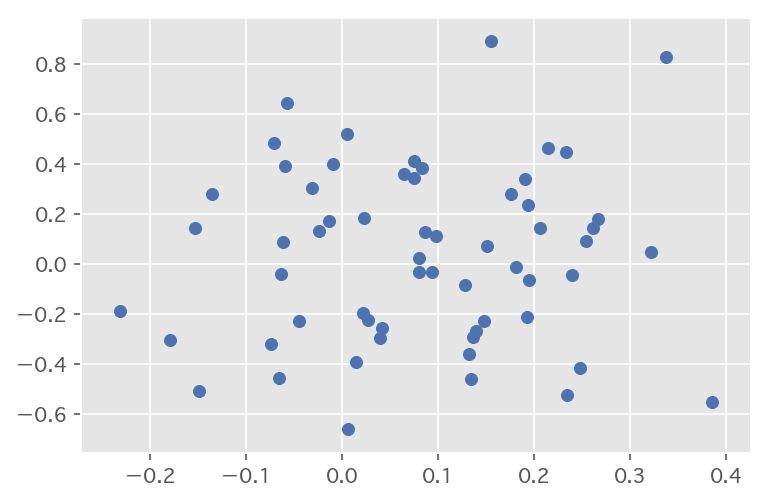

In [58]:
df[["positive_inhibition", "negative_facilitation"]]
plt.scatter(df["positive_inhibition"], df["negative_facilitation"])

In [59]:
df

,all_imp,all_det,pos_imp,pos_det,neg_imp,neg_det,positive_inhibition,negative_facilitation
チーム,,,,,,,,
カブス2018,0.800345,0.685855,0.935288,0.494765,0.366353,0.966733,-0.134943,0.280878
カブス2017,0.952158,1.057526,0.697710,0.927807,0.910688,1.149812,0.254448,0.092285
ロイヤルズ2018,0.956857,0.727179,0.717269,1.046665,0.865207,0.682247,0.239588,-0.044932
ロイヤルズ2017,1.120857,0.848346,1.351657,0.922593,0.652089,0.659215,-0.230800,-0.189132
ヤンキース2018,1.161285,1.136856,0.927381,0.866718,1.022115,1.585683,0.233904,0.448827
ヤンキース2017,1.029821,0.863357,0.795191,0.741985,1.668622,0.341245,0.234630,-0.522112
ブルージェイズ2018,0.862896,1.100316,0.820970,0.963120,0.853265,0.845898,0.041926,-0.254417
ブルージェイズ2017,1.017999,0.931079,1.081197,0.836765,0.574411,0.890252,-0.063198,-0.040827
パイレーツ2018,0.936735,0.704679,0.913574,0.618542,1.140869,0.887614,0.023161,0.182935


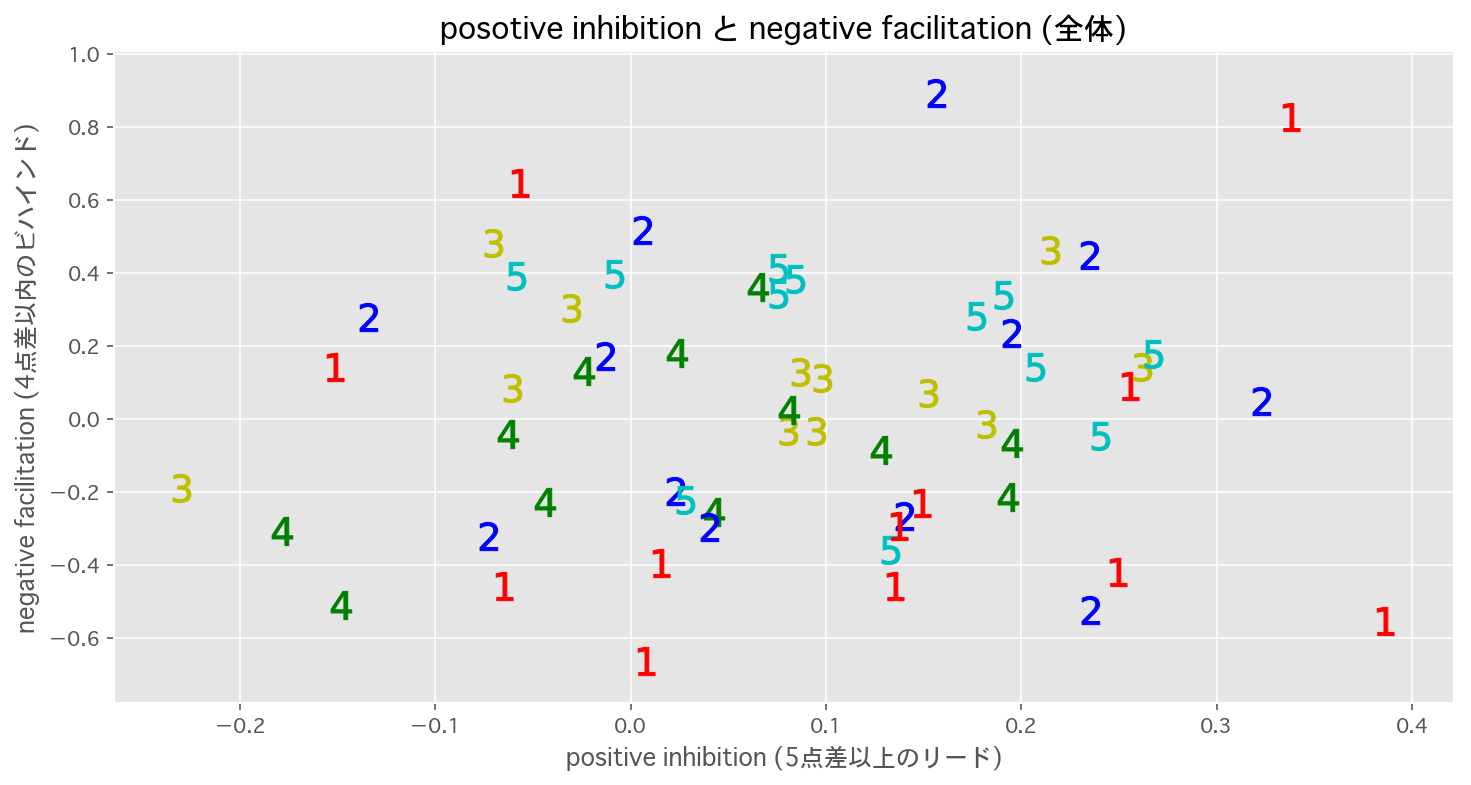

In [60]:
plt.figure(figsize=(12, 6))
colors = ["r", "b", "y", "g", "c"]
for team in df.index:
    pos_inh = df.loc[team, "positive_inhibition"]
    neg_fac = df.loc[team, "negative_facilitation"]
    plt.scatter([pos_inh], [neg_fac], marker="${}$".format(ranking(team[:-4], int(team[-4:]))), color=colors[ranking(team[:-4], int(team[-4:]))-1], s=200)
plt.title("posotive inhibition と negative facilitation (全体)", fontsize=15)
plt.xlabel("positive inhibition (5点差以上のリード)")
plt.ylabel("negative facilitation (4点差以内のビハインド)")

In [61]:
order_pos_dict = defaultdict(int)
for teamyear in df.index:
    team = teamyear[:-4]
    year = int(teamyear[-4:])
    order_pos_dict[ranking(team, year)] += df.loc[teamyear, "positive_inhibition"]

In [62]:
order_pos_dict

defaultdict(int,
            {1: 1.3897382144986392,
             2: 1.1252652296400938,
             3: 0.77279448296144138,
             4: 0.26528121154131901,
             5: 1.4038242318999208})

In [63]:
order_neg_dict = defaultdict(int)
for teamyear in df.index:
    team = teamyear[:-4]
    year = int(teamyear[-4:])
    order_neg_dict[ranking(team, year)] += df.loc[teamyear, "negative_facilitation"]

In [64]:
order_neg_dict

defaultdict(int,
            {1: -1.7470987433636116,
             2: 1.0024905509089419,
             3: 1.5293823419314156,
             4: -0.994470365344297,
             5: 2.2521440898661567})

In [65]:
res_df = pd.DataFrame(np.array([list(order_pos_dict.values()), list(order_neg_dict.values())]), columns=[1, 2, 3, 4, 5], index=["positive_inhibition", "negative_facilitation"]).T

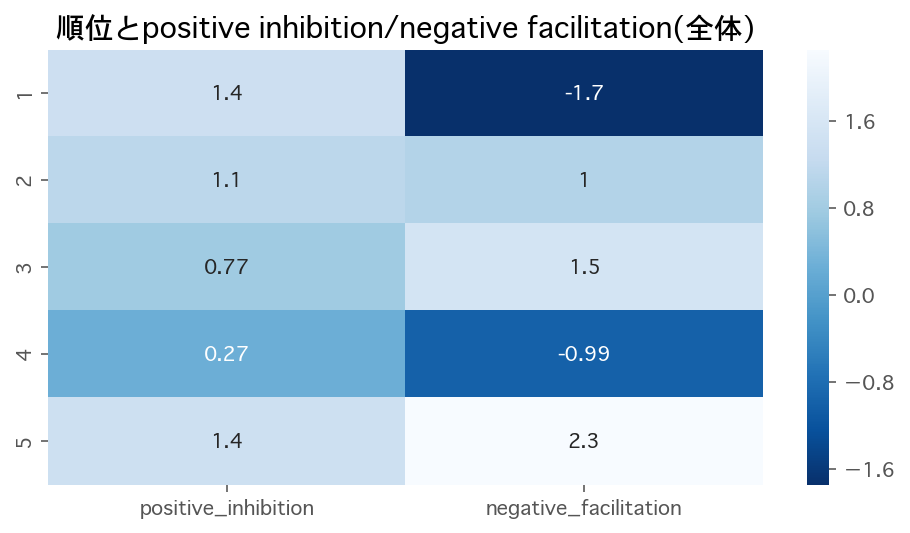

In [66]:
import seaborn as sns
plt.figure(figsize=(8, 4))
sns.heatmap(res_df, cmap='Blues_r', annot=True)
plt.title("順位とpositive inhibition/negative facilitation(全体)")

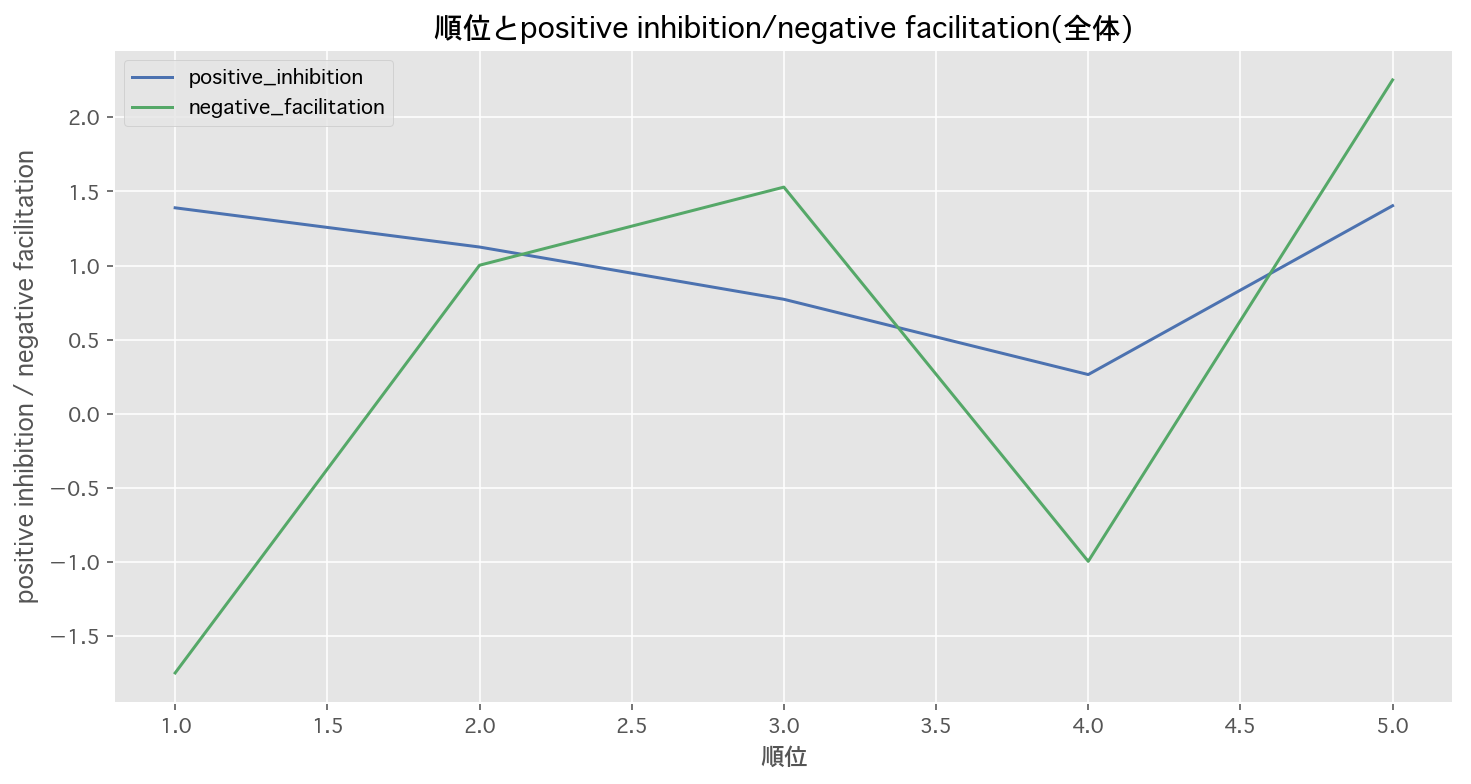

In [67]:
pd.DataFrame([list(order_pos_dict.values()), list(order_neg_dict.values())], index=["positive_inhibition", "negative_facilitation"], columns=[1, 2, 3, 4, 5]).T.plot(figsize=(12, 6))
plt.title("順位とpositive inhibition/negative facilitation(全体)")
plt.xlabel("順位")
plt.ylabel("positive inhibition / negative facilitation")

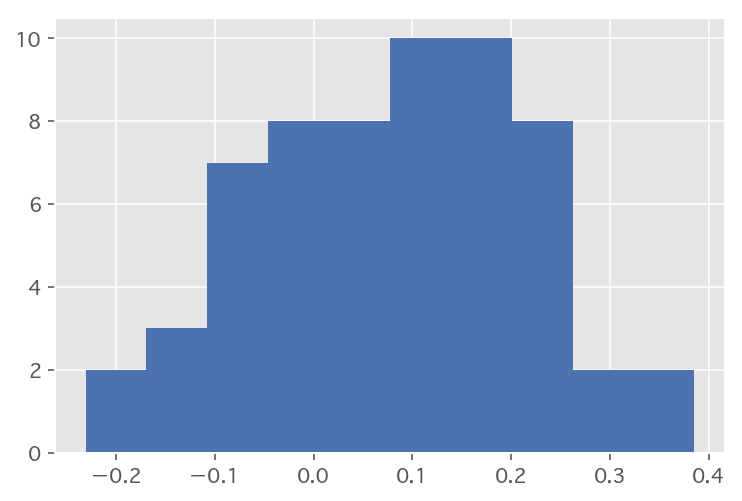

In [68]:
df.loc[:, "positive_inhibition"].hist()

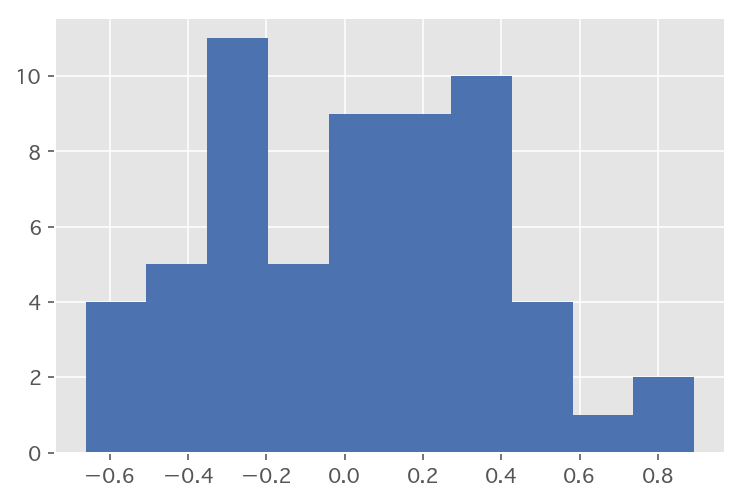

In [69]:
df.loc[:, "negative_facilitation"].hist()

In [70]:
def test(merged_array, title="", xlabel="", ylabel=""):
    x = merged_array[:, 0] #説明変数
    y = merged_array[:, 1] #目的変数
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit()
    a = results.params[0]
    b = results.params[1]
    plt.figure(figsize=(12, 6))
    plt.scatter(x, y, color="b")
    plt.plot(x, a+b*x)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    print("p-values : ", results.pvalues)

In [71]:
winning_rate_df = pd.read_csv(os.path.join(DATA_DIR, "winning_rate.csv"), index_col=0)
        
def winning_rate(team, year=2018):
    # year = 2018 or 2017 or "mean"
    return winning_rate_df[str(year)][team]

### 勝率とpositive inhibitionの関係

In [113]:
df_year = df[df.index.str.contains(str(2018))][["positive_inhibition"]]
df_year.index = [elem[:-4] for elem in list(df_year.index)]
merged_array = pd.concat([df_year, winning_rate_df[[str(2018)]]], axis=1).values
df_year = df[df.index.str.contains(str(2017))][["positive_inhibition"]]
df_year.index = [elem[:-4] for elem in list(df_year.index)]
merged_array = np.concatenate([merged_array, pd.concat([df_year, winning_rate_df[[str(2017)]]], axis=1).values])

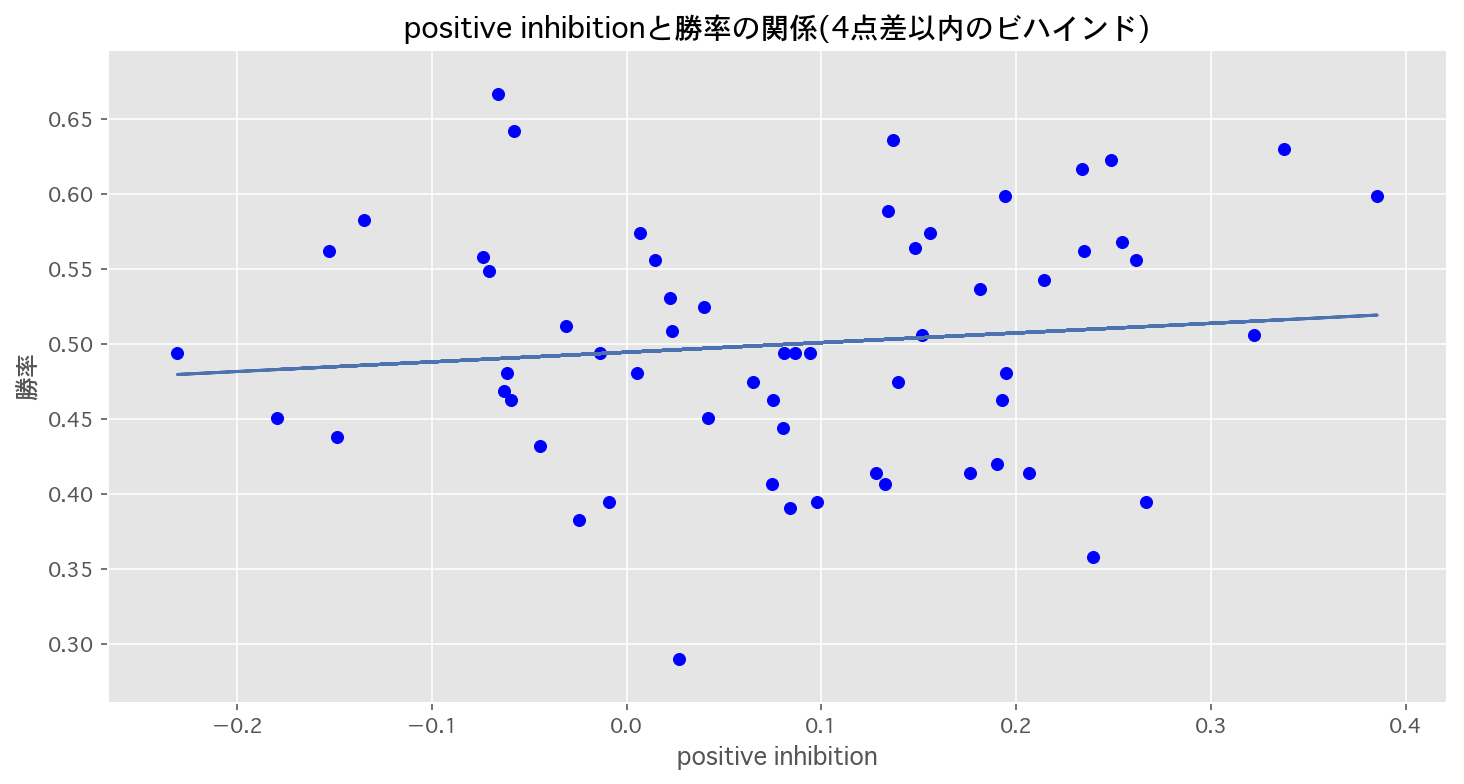

p-values :  [  3.41640753e-44   4.08078524e-01]


In [114]:
test(merged_array, "positive inhibitionと勝率の関係(4点差以内のビハインド)", "positive inhibition", "勝率")

### 勝率とnegative facilitationの関係

In [74]:
df_year = df[df.index.str.contains(str(2018))][["negative_facilitation"]]
df_year.index = [elem[:-4] for elem in list(df_year.index)]
merged_array = pd.concat([df_year, winning_rate_df[[str(2018)]]], axis=1).values
df_year = df[df.index.str.contains(str(2017))][["negative_facilitation"]]
df_year.index = [elem[:-4] for elem in list(df_year.index)]
merged_array = np.concatenate([merged_array, pd.concat([df_year, winning_rate_df[[str(2017)]]], axis=1).values])

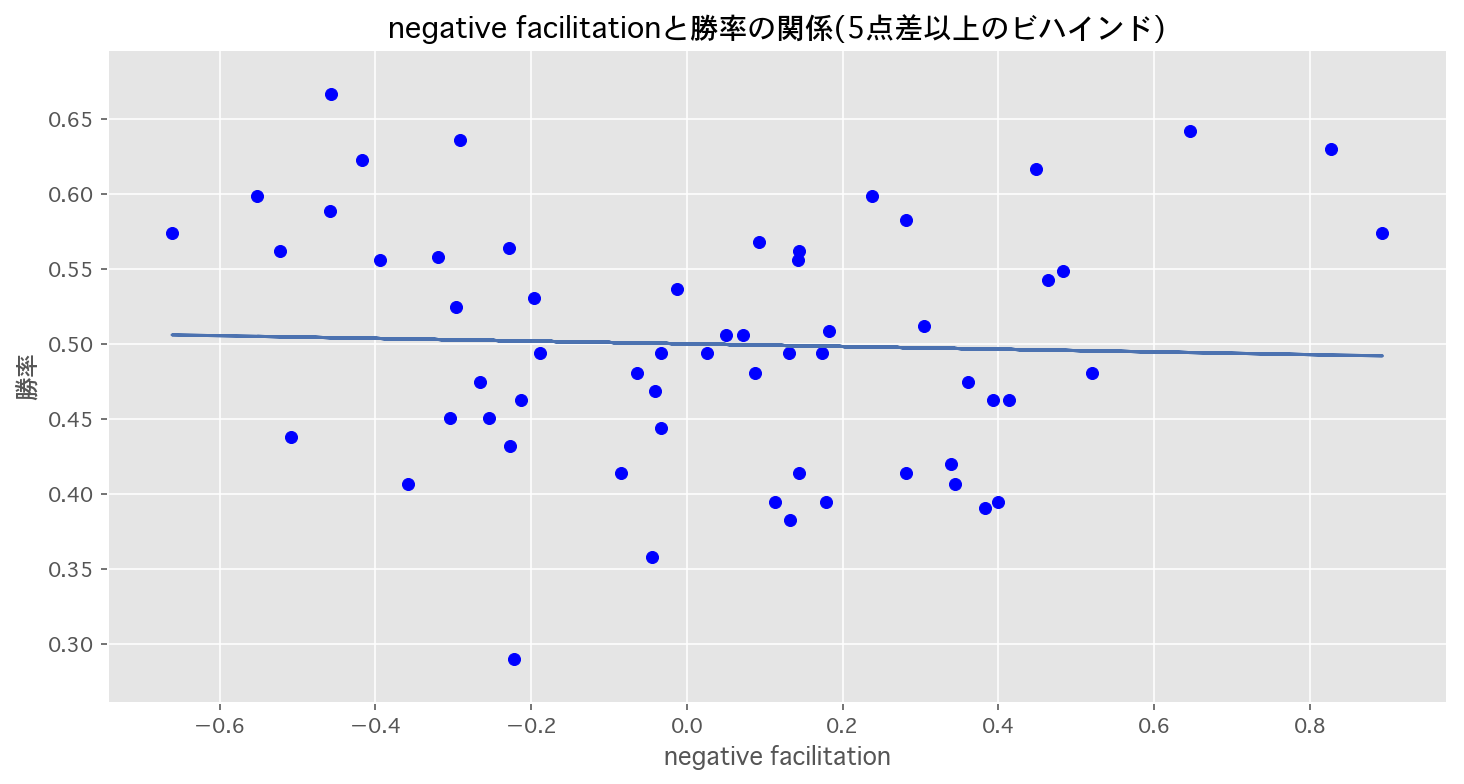

p-values :  [  4.25875388e-48   7.67145696e-01]


In [75]:
test(merged_array, "negative facilitationと勝率の関係(5点差以上のビハインド)", "negative facilitation", "勝率")

In [111]:
%%latex
$$
\begin{eqnarray}
positive~inhibition &=& \mathbb{E}[\text{直後の得点}|\text{流れが良い}] - \mathbb{E}[\text{直後の得点}|\text{大差リード&流れが良い}] \\
&=& \text{大差で勝っている時のチャンスでどれだけ気を抜くか} \\ \\
negative~facilitation &=& \mathbb{E}[\text{直後の得点}|\text{僅差ビハインド&流れが悪い}] - \mathbb{E}[\text{直後の得点}|\text{流れが悪い}] \\
&=& \text{僅差で負けている時にピンチでどれだけ粘れるか} \\
\end{eqnarray}
$$

<IPython.core.display.Latex object>

In [115]:
#event_df

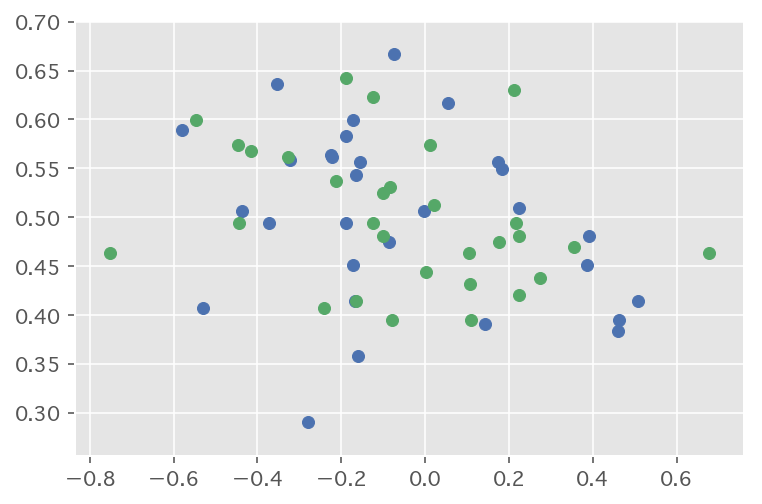

In [46]:
# 勝率とpositive inhibitionの関係
year = 2018
df_year = df[df.index.str.contains(str(year))][["positive_inhibition"]]
df_year.index = [elem[:-4] for elem in list(df_year.index)]
merged_df = pd.concat([df_year, winning_rate_df[[str(year)]]], axis=1)
plt.scatter(merged_df.positive_inhibition, merged_df[str(year)])

year = 2017
df_year = df[df.index.str.contains(str(year))][["positive_inhibition"]]
df_year.index = [elem[:-4] for elem in list(df_year.index)]
merged_df = pd.concat([df_year, winning_rate_df[[str(year)]]], axis=1)
plt.scatter(merged_df.positive_inhibition, merged_df[str(year)])

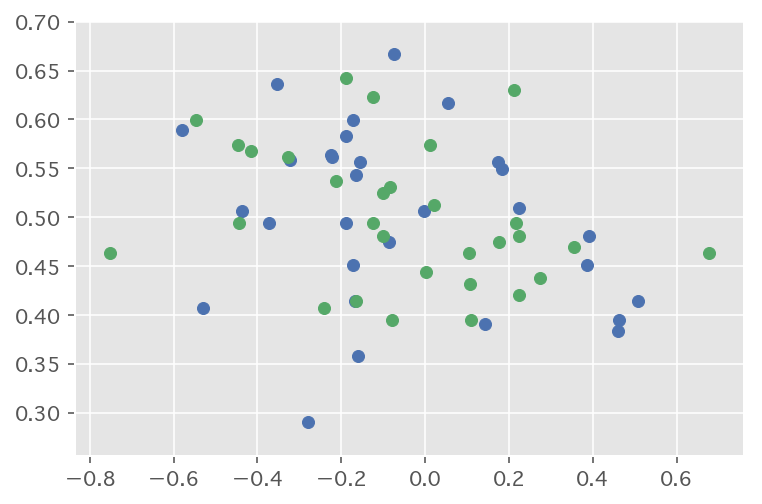

In [55]:
# 勝率とpositive inhibitionの関係
merged_df = None
for year in [2018, 2017]:
    df_year = df[df.index.str.contains(str(year))][["positive_inhibition"]]
    df_year.index = [elem[:-4] for elem in list(df_year.index)]
    merged_df = pd.concat([df_year, winning_rate_df[[str(year)]]], axis=1)
    plt.scatter(merged_df.positive_inhibition, merged_df[str(year)])
plt.show()

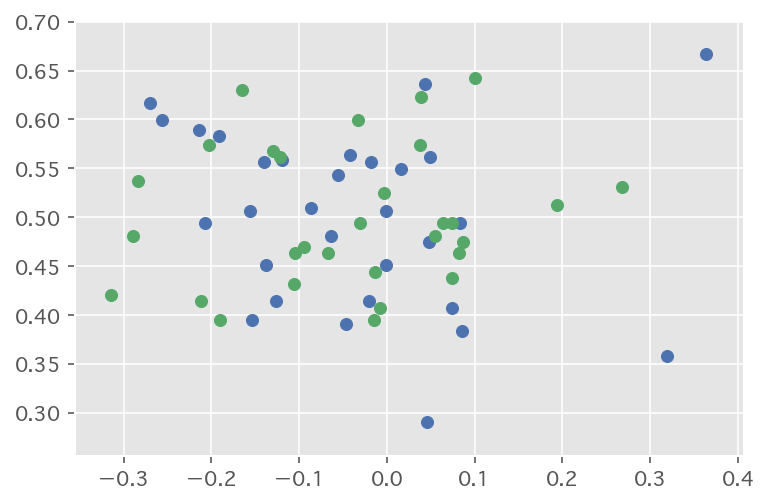

In [49]:
# 勝率とnegative facilitationの関係
for year in [2018, 2017]:
    df_year = df[df.index.str.contains(str(year))][["negative_facilitation"]]
    df_year.index = [elem[:-4] for elem in list(df_year.index)]
    merged_df = pd.concat([df_year, winning_rate_df[[str(year)]]], axis=1)
    plt.scatter(merged_df.negative_facilitation, merged_df[str(year)])